In [1]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.9 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
# load the whole dataset, for data info
all_ds   = tfds.load("eurosat", with_info=True)
# load training, testing & validation sets, splitting by 60%, 20% and 20% respectively
train_ds = tfds.load("eurosat", split="train[:60%]")
test_ds  = tfds.load("eurosat", split="train[60%:80%]")
valid_ds = tfds.load("eurosat", split="train[80%:]")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/2.0.0.incompleteUOL3RC/eurosat-train.tfrecord*...:   0%|      …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


In [4]:
# the class names
class_names = all_ds[1].features["label"].names
# total number of classes (10)
num_classes = len(class_names)
num_examples = all_ds[1].splits["train"].num_examples

Text(0.5, 1.0, 'Bar Plot showing Number of Samples on Each Class')

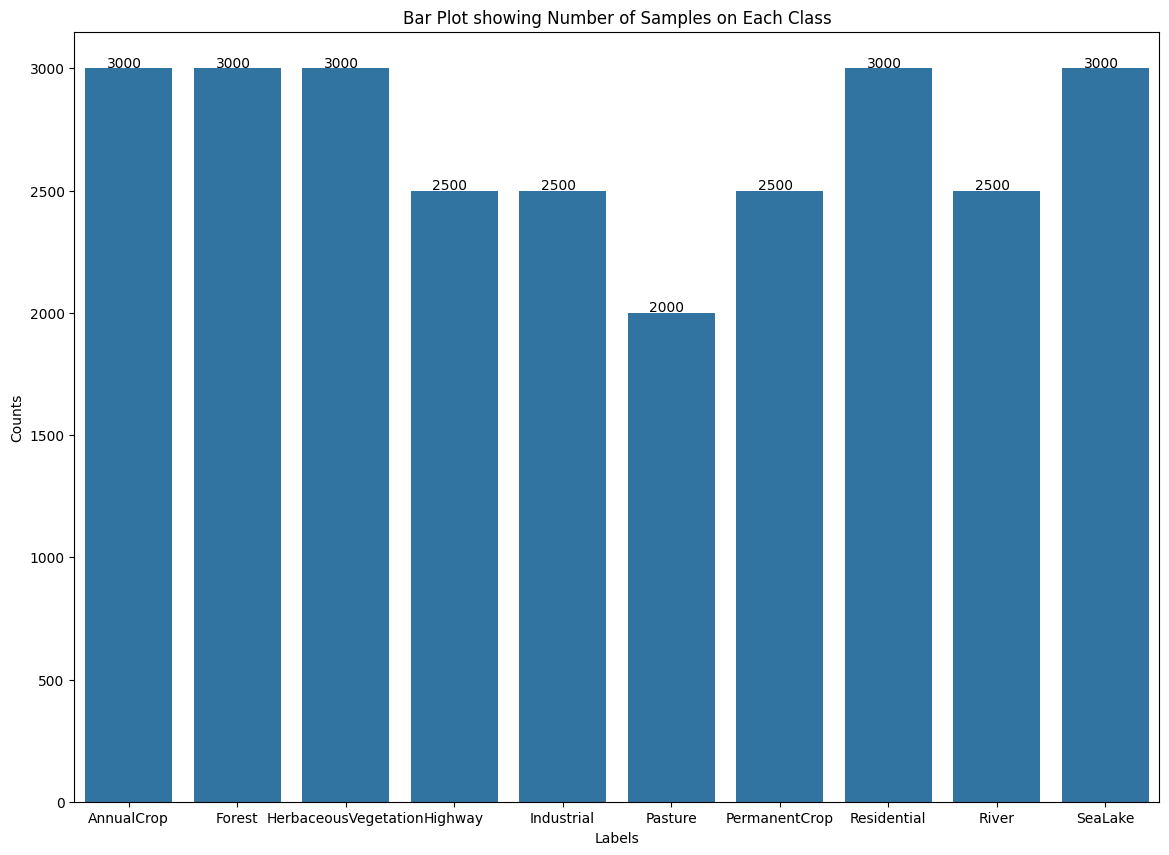

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(14,10))
labels, counts = np.unique(np.fromiter(all_ds[0]["train"].map(lambda x: x["label"]), np.int32),
                       return_counts=True)

plt.ylabel('Counts')
plt.xlabel('Labels')
sns.barplot(x = [class_names[l] for l in labels], y = counts, ax=ax)
for i, x_ in enumerate(labels):
  ax.text(x_-0.2, counts[i]+5, counts[i])
# set the title
ax.set_title("Bar Plot showing Number of Samples on Each Class")
# save the image
# plt.savefig("class_samples.png")

In [6]:
def prepare_for_training(ds, cache=True, batch_size=64, shuffle_buffer_size=1000):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  ds = ds.map(lambda d: (d["image"], tf.one_hot(d["label"], num_classes)))
  # shuffle the dataset
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  # Repeat forever
  ds = ds.repeat()
  # split to batches
  ds = ds.batch(batch_size)
  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return ds

In [7]:
batch_size = 64

# preprocess training & validation sets
train_ds = prepare_for_training(train_ds, batch_size=batch_size)
valid_ds = prepare_for_training(valid_ds, batch_size=batch_size)

In [8]:
# validating shapes
for el in valid_ds.take(1):
  print(el[0].shape, el[1].shape)
for el in train_ds.take(1):
  print(el[0].shape, el[1].shape)

(64, 64, 64, 3) (64, 10)
(64, 64, 64, 3) (64, 10)


In [9]:
# take the first batch of the training set
batch = next(iter(train_ds))

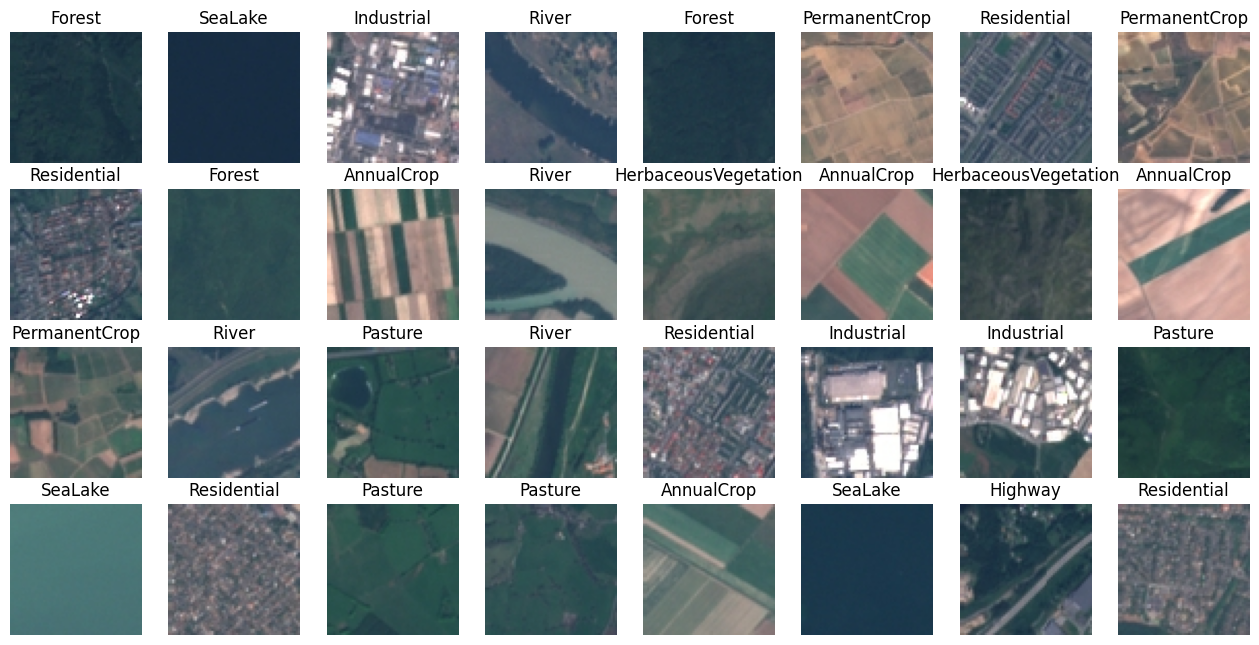

In [10]:
def show_batch(batch):
  plt.figure(figsize=(16, 16))
  for n in range(min(32, batch_size)):
      ax = plt.subplot(batch_size//8, 8, n + 1)
      # show the image
      plt.imshow(batch[0][n])
      # and put the corresponding label as title upper to the image
      plt.title(class_names[tf.argmax(batch[1][n].numpy())])
      plt.axis('off')
      plt.savefig("sample-images.png")

# showing a batch of images along with labels
show_batch(batch)

In [11]:
model_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2"

# download & load the layer as a feature vector
keras_layer = hub.KerasLayer(model_url, output_shape=[1280], trainable=True)

In [12]:
m = tf.keras.Sequential([
  keras_layer,
  tf.keras.layers.Dense(num_classes, activation="softmax")
])

# build the model with input image shape as (64, 64, 3)
m.build([None, 64, 64, 3])
m.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy", tfa.metrics.F1Score(num_classes)])

In [13]:
m.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              117746848 
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 117759658 (449.22 MB)
Trainable params: 117247082 (447.26 MB)
Non-trainable params: 512576 (1.96 MB)
_________________________________________________________________


In [14]:
model_name = "satellite-classification"
model_path = os.path.join("results", model_name + ".h5")
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path, save_best_only=True, verbose=1)

In [15]:
# set the training & validation steps since we're using .repeat() on our dataset
# number of training steps
n_training_steps   = int(num_examples*0.8) // batch_size
# number of validation steps
n_validation_steps = int(num_examples*0.2) // batch_size

In [27]:
# train the model
history = m.fit(
    train_ds, validation_data=valid_ds,
    steps_per_epoch=n_training_steps,
    validation_steps=n_validation_steps,
    verbose=1, epochs=5,
    callbacks=[model_checkpoint])

Epoch 1/5
337/337 [==============================] - ETA: 0s - loss: 0.1953 - accuracy: 0.9428 - f1_score: 0.9415
Epoch 1: val_loss improved from 0.19483 to 0.15341, saving model to results/satellite-classification.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


337/337 [==============================] - 229s 679ms/step - loss: 0.1953 - accuracy: 0.9428 - f1_score: 0.9415 - val_loss: 0.1534 - val_accuracy: 0.9483 - val_f1_score: 0.9445
Epoch 2/5
337/337 [==============================] - ETA: 0s - loss: 0.1392 - accuracy: 0.9573 - f1_score: 0.9565
Epoch 2: val_loss improved from 0.15341 to 0.10537, saving model to results/satellite-classification.h5
337/337 [==============================] - 236s 700ms/step - loss: 0.1392 - accuracy: 0.9573 - f1_score: 0.9565 - val_loss: 0.1054 - val_accuracy: 0.9648 - val_f1_score: 0.9631
Epoch 3/5
337/337 [==============================] - ETA: 0s - loss: 0.0919 - accuracy: 0.9718 - f1_score: 0.9711
Epoch 3: val_loss improved from 0.10537 to 0.07874, saving model to results/satellite-classification.h5
337/337 [==============================] - 242s 719ms/step - loss: 0.0919 - accuracy: 0.9718 - f1_score: 0.9711 - val_loss: 0.0787 - val_accuracy: 0.9738 - val_f1_score: 0.9727
Epoch 4/5
337/337 [==============

In [28]:
# load the best weights
m.load_weights(model_path)

In [29]:
# number of testing steps
n_testing_steps = int(all_ds[1].splits["train"].num_examples * 0.2)
# get all testing images as NumPy array
images = np.array([ d["image"] for d in test_ds.take(n_testing_steps) ])
print("images.shape:", images.shape)
# get all testing labels as NumPy array
labels = np.array([ d["label"] for d in test_ds.take(n_testing_steps) ])
print("labels.shape:", labels.shape)

images.shape: (5400, 64, 64, 3)
labels.shape: (5400,)


In [30]:
# feed the images to get predictions
predictions = m.predict(images)
# perform argmax to get class index
predictions = np.argmax(predictions, axis=1)
print("predictions.shape:", predictions.shape)

169/169 [==============================] - 10s 62ms/step
predictions.shape: (5400,)


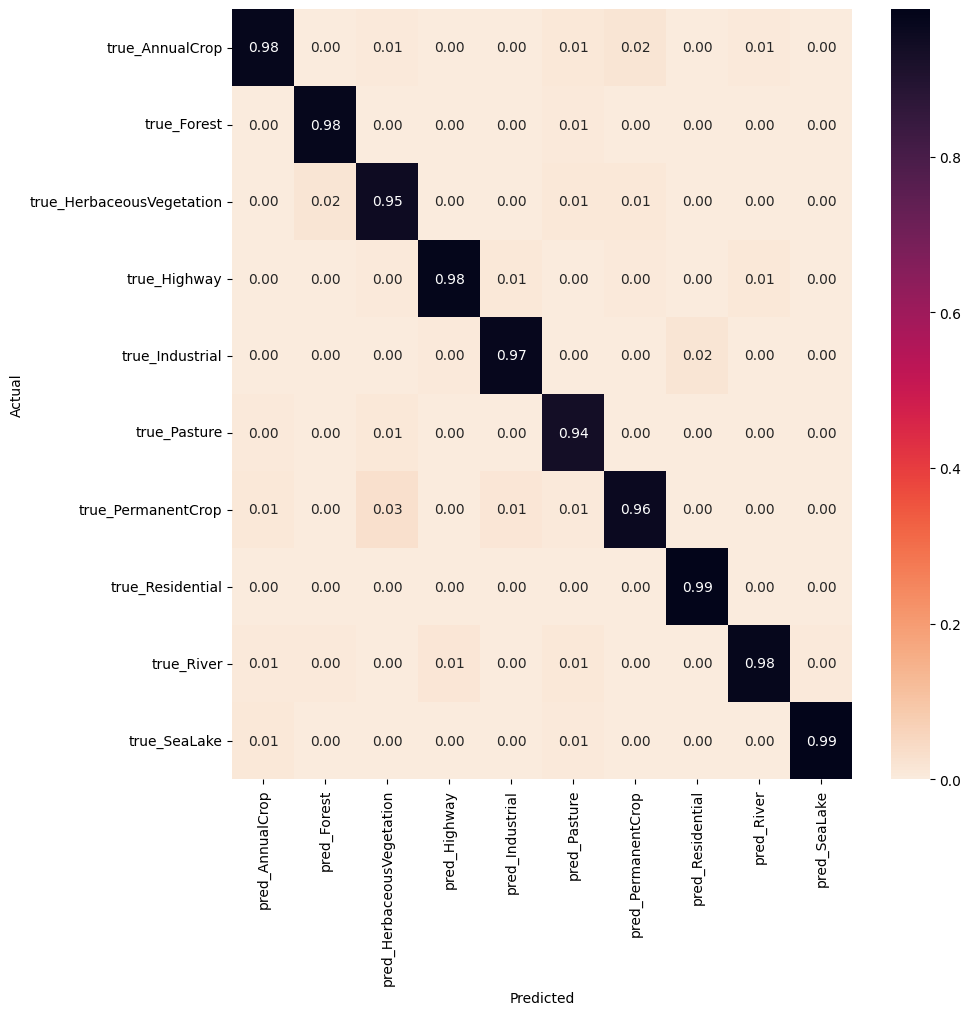

In [31]:
# compute the confusion matrix
cmn = tf.math.confusion_matrix(labels, predictions).numpy()
# normalize the matrix to be in percentages
cmn = cmn.astype('float') / cmn.sum(axis=0)[:, np.newaxis]
# make a plot for the confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f',
            xticklabels=[f"pred_{c}" for c in class_names],
            yticklabels=[f"true_{c}" for c in class_names],
            # cmap="Blues")
            cmap="rocket_r")
plt.ylabel('Actual')
plt.xlabel('Predicted')
# plot the resulting confusion matrix
plt.savefig("confusion-matrix.png")
#plt.show()

In [32]:
from sklearn.metrics import f1_score
accuracy = tf.keras.metrics.Accuracy()
accuracy.update_state(labels, predictions)
print("Accuracy:", accuracy.result().numpy())
print("F1 Score:", f1_score(labels, predictions, average="macro"))

Accuracy: 0.9714815
F1 Score: 0.9710551890317867


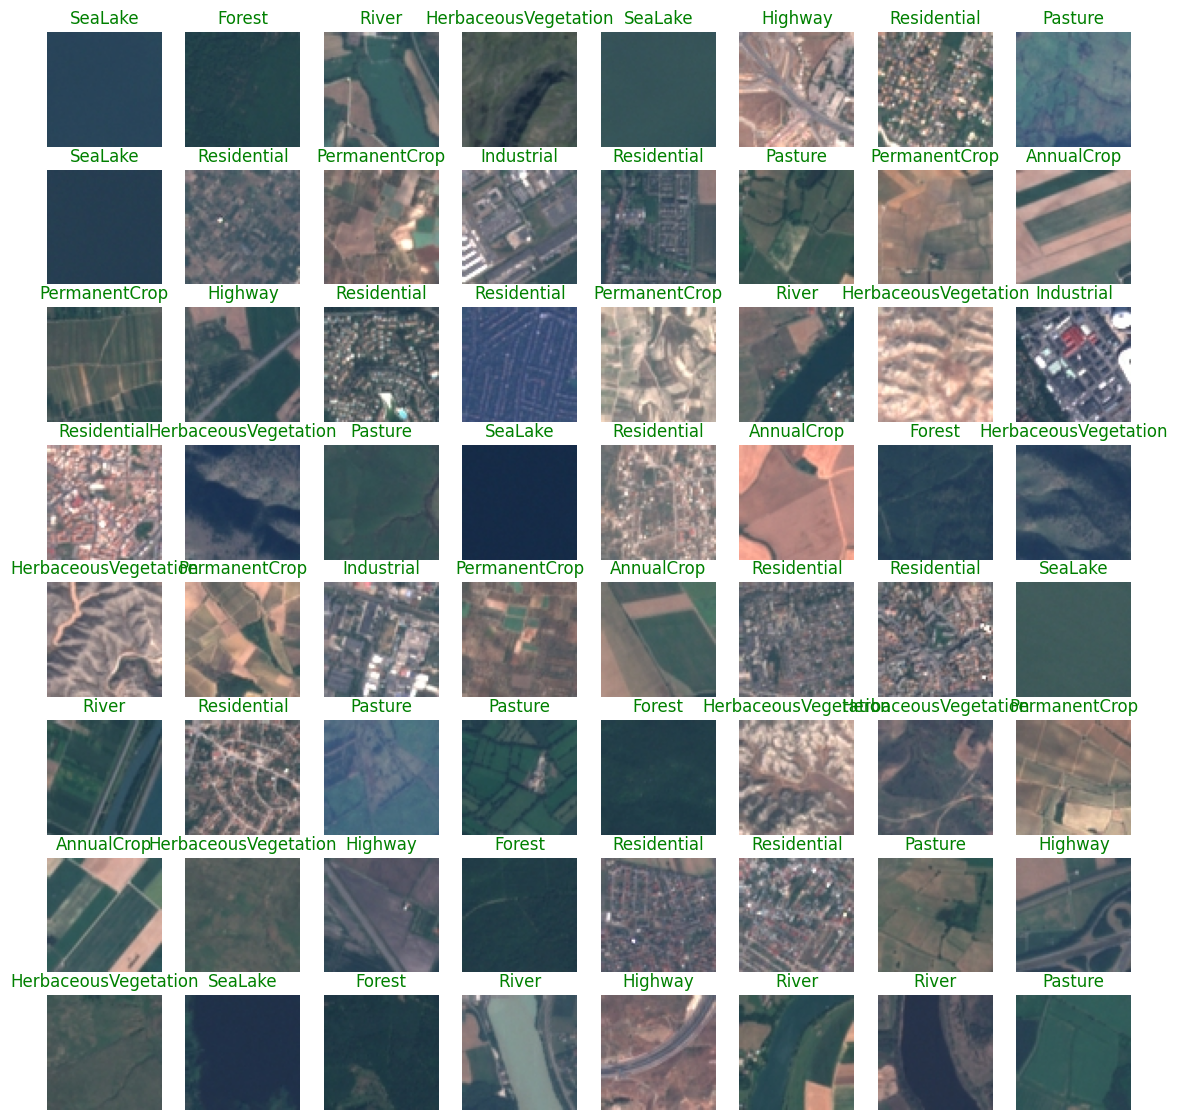

In [33]:
def show_predicted_samples():
  plt.figure(figsize=(14, 14))
  for n in range(64):
      ax = plt.subplot(8, 8, n + 1)
      # show the image
      plt.imshow(images[n])
      # and put the corresponding label as title upper to the image
      if predictions[n] == labels[n]:
        # correct prediction
        ax.set_title(class_names[predictions[n]], color="green")
      else:
        # wrong prediction
        ax.set_title(f"{class_names[predictions[n]]}/T:{class_names[labels[n]]}", color="red")
      plt.axis('off')
      plt.savefig("predicted-sample-images.png")

# showing a batch of images along with predictions labels
show_predicted_samples()